# Route Simulation

In [1]:
import csv
from typing import List, Dict, Set, Tuple
import glob
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as ti
import warnings # to suppress warnings
import pickle
import os.path
from datetime import datetime
warnings.filterwarnings('ignore')

from model import Stop, Edge, StopNetwork, Route, Charger, Bus, Simulation

# Simulations on all buses in Manhattan

## Initialize stop network

In [2]:
stop_network = StopNetwork()
for filepath in glob.iglob("../data/routes/M*_stop_graph.csv"):
    route_name = filepath[filepath.rfind(os.path.sep) + 1:filepath.find("_")]
    #print(filepath)
    #print(route_name)
    stop_network.add_from_csv(route_name, filepath)
stop_network.stops["Michael J. Quill Depot (MQ)"].add_chargers(num_chargers=20, )
stop_network.stops["Michael J. Quill Depot (MQ)"].set_to_be_depot()
stop_network.stops["Michael J. Quill Depot (MQ)"].charging_capacity=11700
for route in stop_network.routes:
    stop_network.stops["Michael J. Quill Depot (MQ)"].Bus_standby.update({route:[]})

#stop_network.add_from_csv("M14D-SBS", "../../data/routes/M14D-SBS_stop_graph.csv")
#stop_network.stops["Michael J. Quill Depot (MQ)"].add_chargers(num_chargers=1)
#stop_network.stops["Michael J. Quill Depot (MQ)"].is_depot = True

## Load MJQ Routes and Buses

In [3]:
with open("../output/MJQ_bus_counts.pkl","rb") as f:
    MJQ_bus_counts = pickle.load(f)

print(MJQ_bus_counts)
#Load the name of all bus routes in Manhattan
#manhattan_routes_data = pd.read_table('../data/routes/manhattan_routes.txt', sep = ',', header = None)
#manhattan_routes_data.columns = ['route','depot']
#error_route = ['M72']
#M1, M22, M8 Took forever to run
#manhattan_routes_data = manhattan_routes_data[~manhattan_routes_data['route'].isin(error_route)]
#manhattan_routes_data = manhattan_routes_data.reset_index(drop=True)

{'M9': 32, 'M14A-SBS': 29, 'M14D-SBS': 43, 'M50': 11, 'M42': 18, 'M20': 16, 'M55': 15, 'M12': 6, 'M22': 17, 'M86-SBS': 24, 'M79-SBS': 20, 'M60-SBS': 34, 'M34-SBS': 20, 'M34A-SBS': 24, 'M23-SBS': 18, 'M66': 22, 'M21': 16, 'M8': 14, 'M57': 21, 'M72': 20}


In [4]:
#stop_network.routes
#stop_network.stops["Michael J. Quill Depot (MQ)"].Bus_standby

In [5]:
#stop_network.stops["Michael J. Quill Depot (MQ)"].Time_ToBe_Launched

## Import MJQ Bus Schedule

In [6]:
with open("../output/MJQ_schedule.pkl","rb") as f:
    MJQ_schedule = pickle.load(f)

stop_network.stops["Michael J. Quill Depot (MQ)"].Time_ToBe_Launched = MJQ_schedule
#print(MJQ_schedule)

## Create Buses in the Network

In [7]:
#NUM_BUSES = 1000
michaeljquill_depot_routes = list(MJQ_bus_counts.keys())
#michaeljquill_depot_routes = ['M104']
speed = 15.33 # Km/h
battery_capacity = 140# KWh
battery_charge = 140 * 0.9 # KWh
energy_use_per_km = 1.84 # KWh / Km
#for bus_id in range(NUM_BUSES):
#    route_name = random.choice(michaeljquill_depot_routes)
#    route_direction = random.choice([direction for direction in stop_network.routes[route_name].stops if not "to depot" in direction])
#    cur_stop_name = random.choice([stop.name for stop in stop_network.routes[route_name].stops[route_direction]])
#    stop_network.add_bus(bus_id, speed, cur_stop_name, route_name, route_direction, battery_capacity, battery_charge*(np.random.rand()*(1-0.3)+0.3), energy_use_per_km)
#    print(route_name, route_direction, cur_stop_name)

bus_id = 0
cur_stop_name = "Michael J. Quill Depot (MQ)"

for route_name in michaeljquill_depot_routes:
    route_direction = stop_network.routes[route_name].get_other_direction(stop_network.stops[cur_stop_name], None)
    for i in range(MJQ_bus_counts[route_name]):
        stop_network.add_bus(bus_id, speed, cur_stop_name, route_name, route_direction, battery_capacity, battery_charge, energy_use_per_km)
        bus_id += 1
    print('Created {0:2} buses of Route {1:8} at {2:10} heading {3:10}'.format(i, route_name, cur_stop_name, route_direction))


Created 31 buses of Route M9       at Michael J. Quill Depot (MQ) heading BATTERY PK CITY via AVENUE C via PK ROW
Created 28 buses of Route M14A-SBS at Michael J. Quill Depot (MQ) heading SELECT BUS LES GRAND-FDR via 14 ST
Created 42 buses of Route M14D-SBS at Michael J. Quill Depot (MQ) heading SELECT BUS CHLSEA PIERS  11 AV via 14 ST
Created 10 buses of Route M50      at Michael J. Quill Depot (MQ) heading EAST SIDE 49 ST-1 AV CROSSTOWN
Created 17 buses of Route M42      at Michael J. Quill Depot (MQ) heading EAST SIDE U N-1 AV CROSSTOWN
Created 15 buses of Route M20      at Michael J. Quill Depot (MQ) heading LINCOLN CENTER 66 ST via 8 AV
Created 14 buses of Route M55      at Michael J. Quill Depot (MQ) heading 44 ST 6 AV
Created  5 buses of Route M12      at Michael J. Quill Depot (MQ) heading MIDTOWN WEST COLUMBUS CIRCLE
Created 16 buses of Route M22      at Michael J. Quill Depot (MQ) heading BATTERY PK CTY
Created 23 buses of Route M86-SBS  at Michael J. Quill Depot (MQ) heading

In [8]:
net_filepath = '../data/Penn_22.csv'
capacity = 100
sim = Simulation(stop_network, net_filepath, capacity)
sim.run(30, 10, '../output/bus_MQ.csv','../output/charger_MQ.csv','../output/charger_rate_MQ.csv')

In [9]:
#stop_network.stops['5 AV/W 38 ST'].edges['to depot of M3'].next_stop

In [10]:
#for bus in stop_network.routes['M3'].buses:
# print(bus.get_next_direction(stop_network.stops['Michael J. Quill Depot (MQ)'], 'to depot of M3'))

stop_network.stops['Michael J. Quill Depot (MQ)'].Delayed_time

0

In [11]:
#stop_network.stops['W 70 ST/FREEDOM PL'].edges['EAST SIDE YORK AV CROSSTOWN M72'].next_stop
#stop_network.stops['WEST 66 ST/FREEDOM PL'].edges['EAST SIDE YORK AV CROSSTOWN M72'].next_stop
#stop_network.stops['MADISON AV/E 65 ST'].edges
#stop_network.routes["M72"].stops
#.stops["EAST SIDE YORK AV CROSSTOWN M72"]:
#    print(i)
#stop_network.routes['M72'].get_other_direction(stop_network.stops['W 66 ST/FREEDOM PL'], 'EAST SIDE YORK AV CROSSTOWN M72')

In [12]:
#for bus in stop_network.routes['M3'].buses:
#    print(bus.cur_stop.edges['EAST VILLAGE 8 ST via 5 AV'].length)

In [13]:
#for bus in stop_network.routes['M3'].buses:
#    print(bus.cur_stop.edges['FT GEORGE 193 ST via MADISON via ST NICH'].length)

In [14]:
#for direction in stop_network.routes['M3'].stops:
#    print(direction)

   Time (s)  Charger 1  Charger 2  Charger 3  Charger 4  Charger 5  Charger 6  \
0         0        0.0        0.0          0          0          0          0   
1        10        0.0        0.0          0          0          0          0   
2        20        0.0        0.0          0          0          0          0   
3        30        0.0        0.0          0          0          0          0   
4        40        0.0        0.0          0          0          0          0   

   Charger 7  Charger 8  Charger 9  ...  Charger 12  Charger 13  Charger 14  \
0          0          0          0  ...           0           0           0   
1          0          0          0  ...           0           0           0   
2          0          0          0  ...           0           0           0   
3          0          0          0  ...           0           0           0   
4          0          0          0  ...           0           0           0   

   Charger 15  Charger 16  Charger 17 

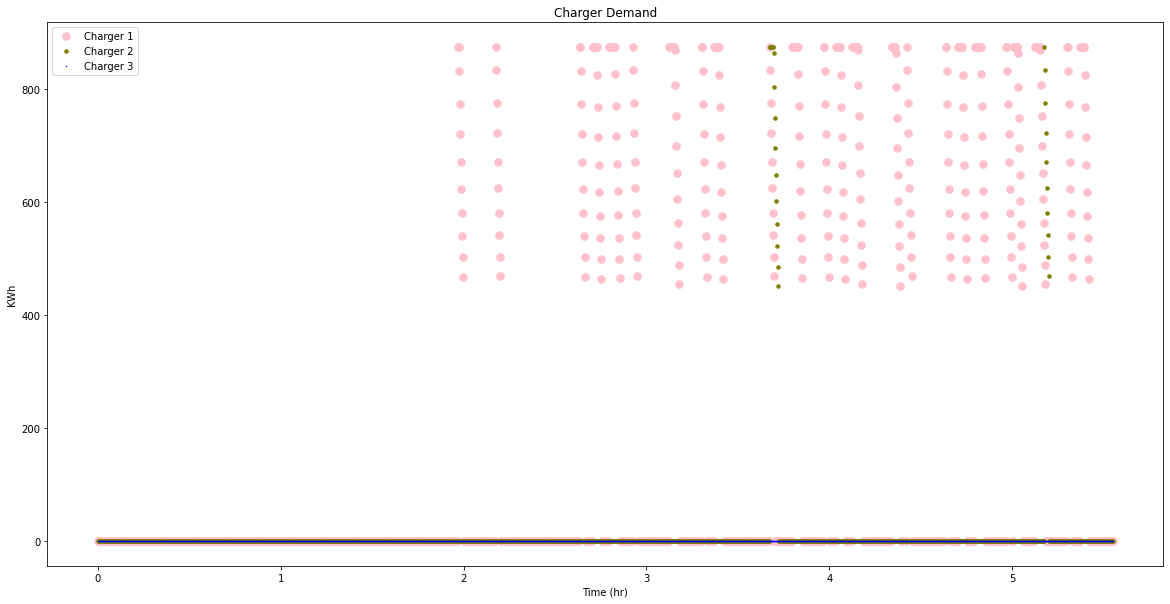

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
df = pd.read_csv('../output/charger_rate.csv',sep=',')
df['Time (hr)']=df['Time (s)']/3600
print(df.head())
plt.figure(figsize=(20, 10)) 
display(plt.plot( 'Time (hr)', 'Charger 1', data=df, marker='.',markersize=15, color='pink', linewidth=0))
display(plt.plot( 'Time (hr)', 'Charger 2', data=df, marker='.', color='olive',markersize=7, linewidth=0))
display(plt.plot( 'Time (hr)', 'Charger 3', data=df, marker='.', color='blue', markersize=1, linewidth=0, linestyle='dashed'))

plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('KWh')
plt.title('Charger Demand')

plt.show()



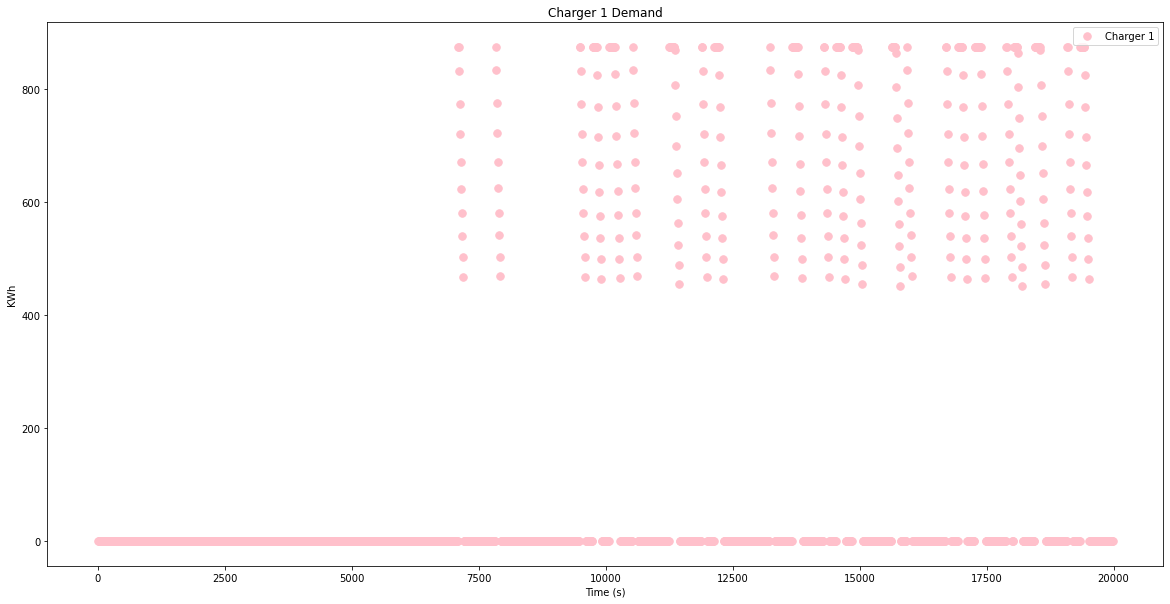

In [16]:
import numpy as np
import pandas as pd
 
df = pd.read_csv('../output/charger_rate.csv',sep=',')
plt.figure(figsize=(20, 10)) 
display(plt.plot( 'Time (s)', 'Charger 1', data=df, marker='.',markersize=15, color='pink', linewidth=0))


plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('KWh')
plt.title('Charger 1 Demand')

plt.show()



      Time (s)  ID Route     Next Stop                 Current Stop  \
297          0   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
717         10   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
1137        20   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
1557        30   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
1977        40   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
2397        50   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
2817        60   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
3237        70   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
3657        80   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   
4077        90   1    M9  E 29 ST/2 AV  Michael J. Quill Depot (MQ)   

                                    Direction  Total Distance (Km)  \
297   BATTERY PK CITY via AVENUE C via PK ROW                  0.0   
717   BATTERY PK CITY via AVENUE C via PK ROW                  0.0   
1137  BA

Text(0.5, 1.0, 'Test Bus')

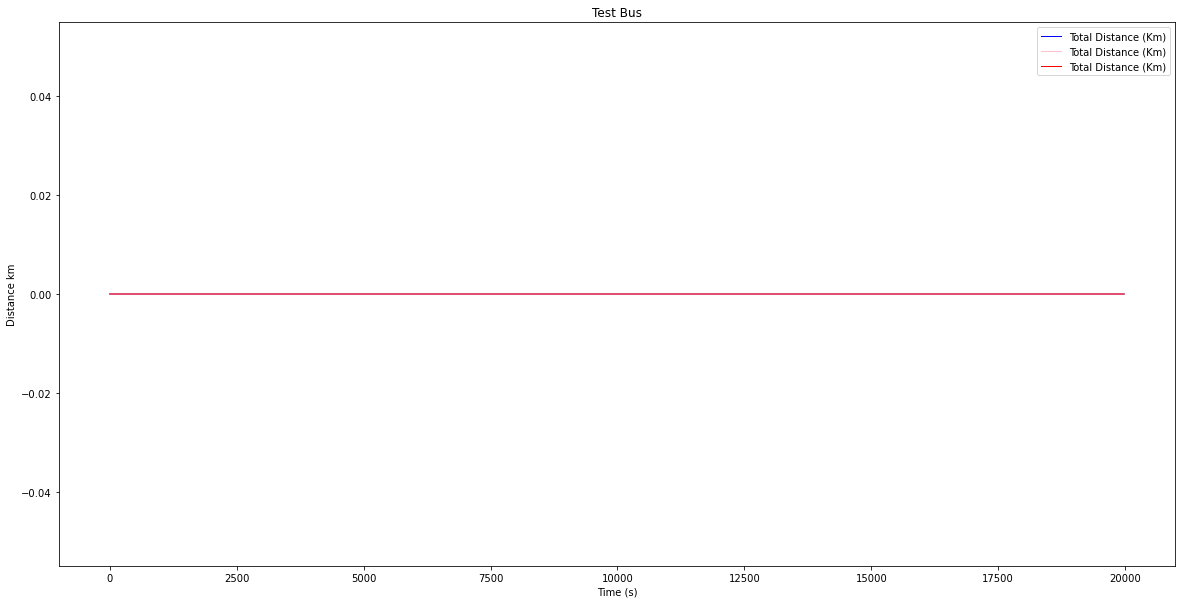

In [17]:
test = pd.read_csv('../output/bus.csv',sep=',')
bus_1=test[test["ID"]==1]
bus_2=test[test["ID"]==2]
bus_3=test[test["ID"]==3]

print(bus_1.head(10))

plt.figure(figsize=(20, 10)) 

display(plt.plot('Time (s)', 'Total Distance (Km)', data=bus_1, marker='', color='blue', linewidth=1))
display(plt.plot('Time (s)', 'Total Distance (Km)', data=bus_2, marker='', color='pink', linewidth=1))
display(plt.plot('Time (s)', 'Total Distance (Km)', data=bus_3, marker='', color='red', linewidth=1))

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Distance km')
plt.title('Test Bus')


   Time (s)  Charger 1  Charger 2  Charger 3  Charger 4  Charger 5  Charger 6  \
0         0        0.0        0.0          0          0          0          0   
1        10        0.0        0.0          0          0          0          0   
2        20        0.0        0.0          0          0          0          0   
3        30        0.0        0.0          0          0          0          0   
4        40        0.0        0.0          0          0          0          0   

   Charger 7  Charger 8  Charger 9  ...  Charger 11  Charger 12  Charger 13  \
0          0          0          0  ...           0           0           0   
1          0          0          0  ...           0           0           0   
2          0          0          0  ...           0           0           0   
3          0          0          0  ...           0           0           0   
4          0          0          0  ...           0           0           0   

   Charger 14  Charger 15  Charger 16 

Text(0.5, 1.0, 'Test Bus')

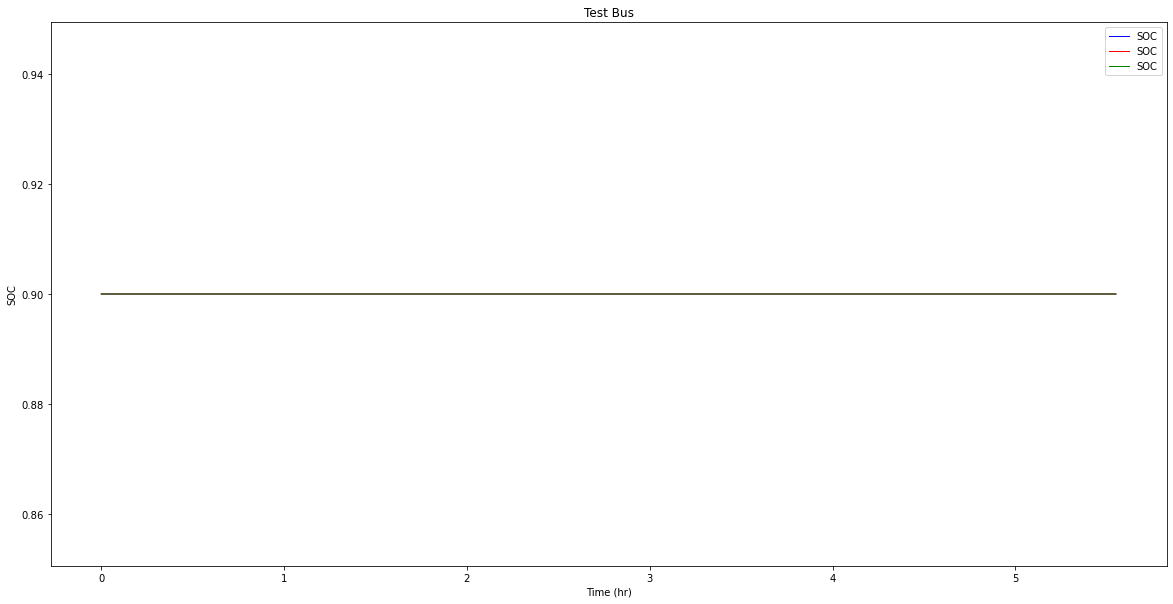

In [18]:
test = pd.read_csv('../output/bus.csv',sep=',')

test['Time (hr)']=test['Time (s)']/3600
print(df.head())

bus_1=test[test["ID"]==1]
bus_2=test[test["ID"]==2]
bus_3=test[test["ID"]==3]


#print(bus_1.head(10))

plt.figure(figsize=(20, 10)) 

display(plt.plot('Time (hr)', 'SOC', data=bus_1, marker='', color='blue', linewidth=1))
display(plt.plot('Time (hr)', 'SOC', data=bus_2, marker='', color='red', linewidth=1))
display(plt.plot('Time (hr)', 'SOC', data=bus_3, marker='', color='green', linewidth=1))


plt.legend()
plt.xlabel('Time (hr)')
plt.ylabel('SOC')
plt.title('Test Bus')


In [19]:
host_cap = pd.read_csv('../data/Penn_22.csv',sep=',',index_col=None)
dff = host_cap[['DateTime','Pennsylvania']]
dff['DateTime']= pd.to_datetime(dff['DateTime'])
dff['Hour'] = dff.DateTime.apply(lambda x: x.hour)

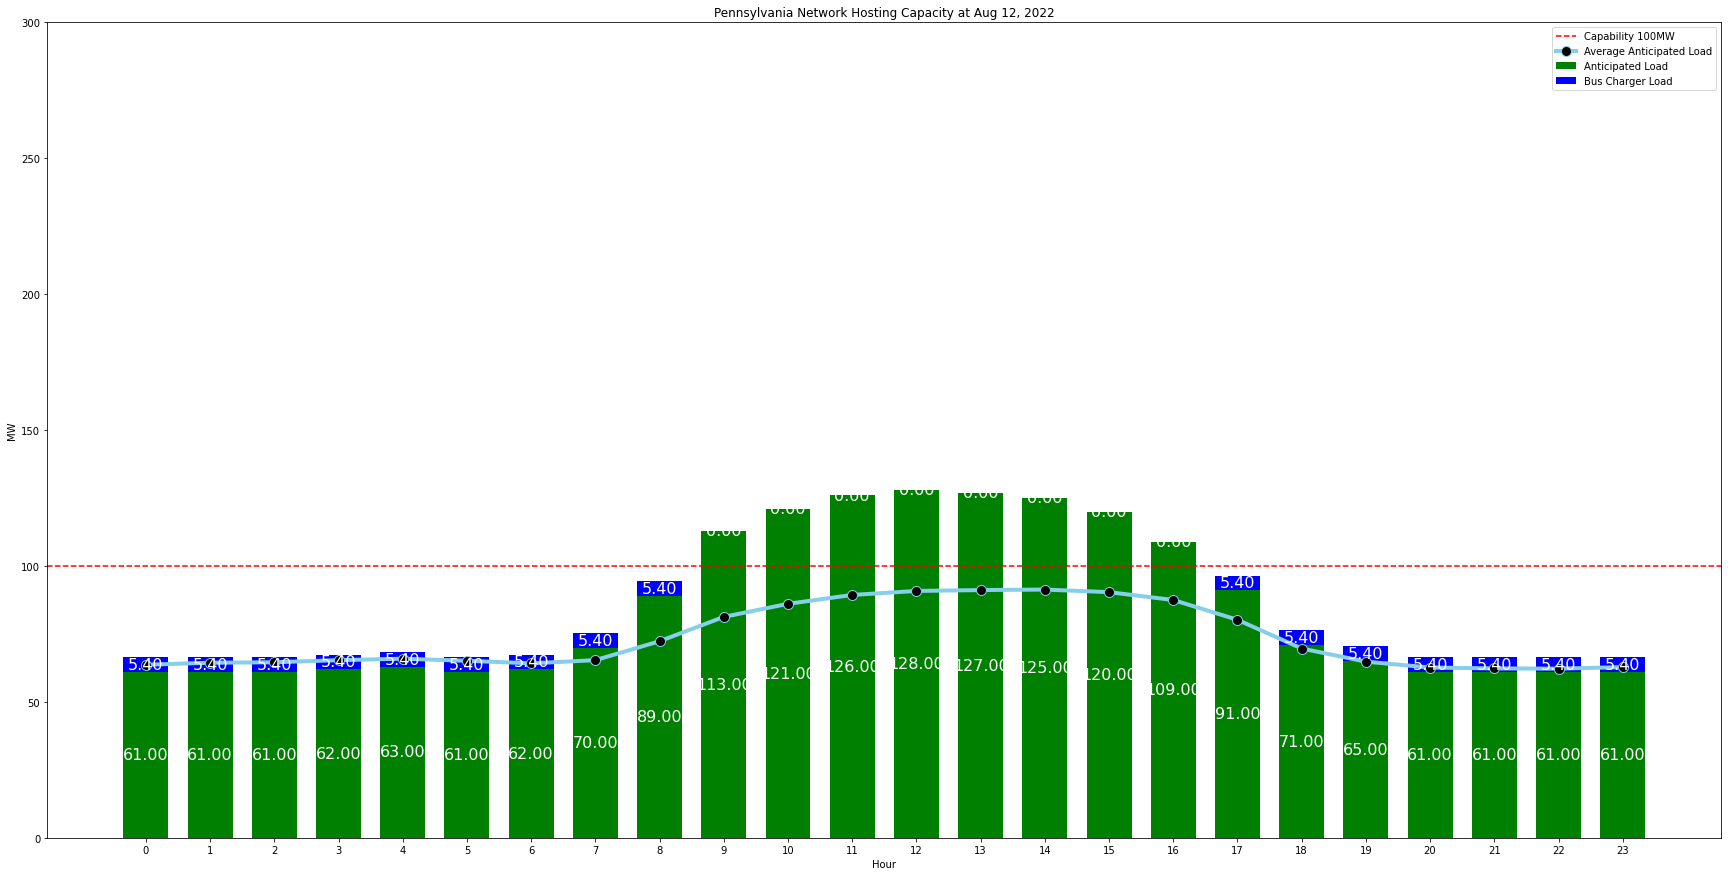

In [20]:
#12 chargers @450kW 
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 
          '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
charger = [5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 0, 0, 0, 0, 0, 0, 0, 0,
          5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4]
load = []
for i in range(0,24):
    ld = dff['Pennsylvania'].loc[5352+i]
    load.append(float(ld))
avg_load = []
for i in range(0,24):
    avg = dff.loc[dff['Hour'] == i, 'Pennsylvania'].mean()
    avg = "%.2f" %avg
    avg_load.append(float(avg))
width = 0.7

fig, ax = plt.subplots(figsize=(30,15))
plt.axhline(y=100, color='r', linestyle='--', label='Capability 100MW')
plt.plot(labels, avg_load, marker='o', markerfacecolor='black', markersize=10, color='skyblue', linewidth=4, label='Average Anticipated Load')
ax1 = ax.bar(labels, load, width, color='green', label='Anticipated Load')
ax2 = ax.bar(labels, charger, width, color='blue', yerr=None, bottom=load, label='Bus Charger Load')
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%.2f" % h1, ha="center", va="center", color="white", fontsize=16)
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%.2f" % h2, ha="center", va="center", color="white", fontsize=16)
ax.set_xlabel('Hour')
ax.set_ylabel('MW')
ax.set_title('Pennsylvania Network Hosting Capacity at Aug 12, 2022')
ax.legend(loc='best')
plt.ylim(0,300)
plt.show()

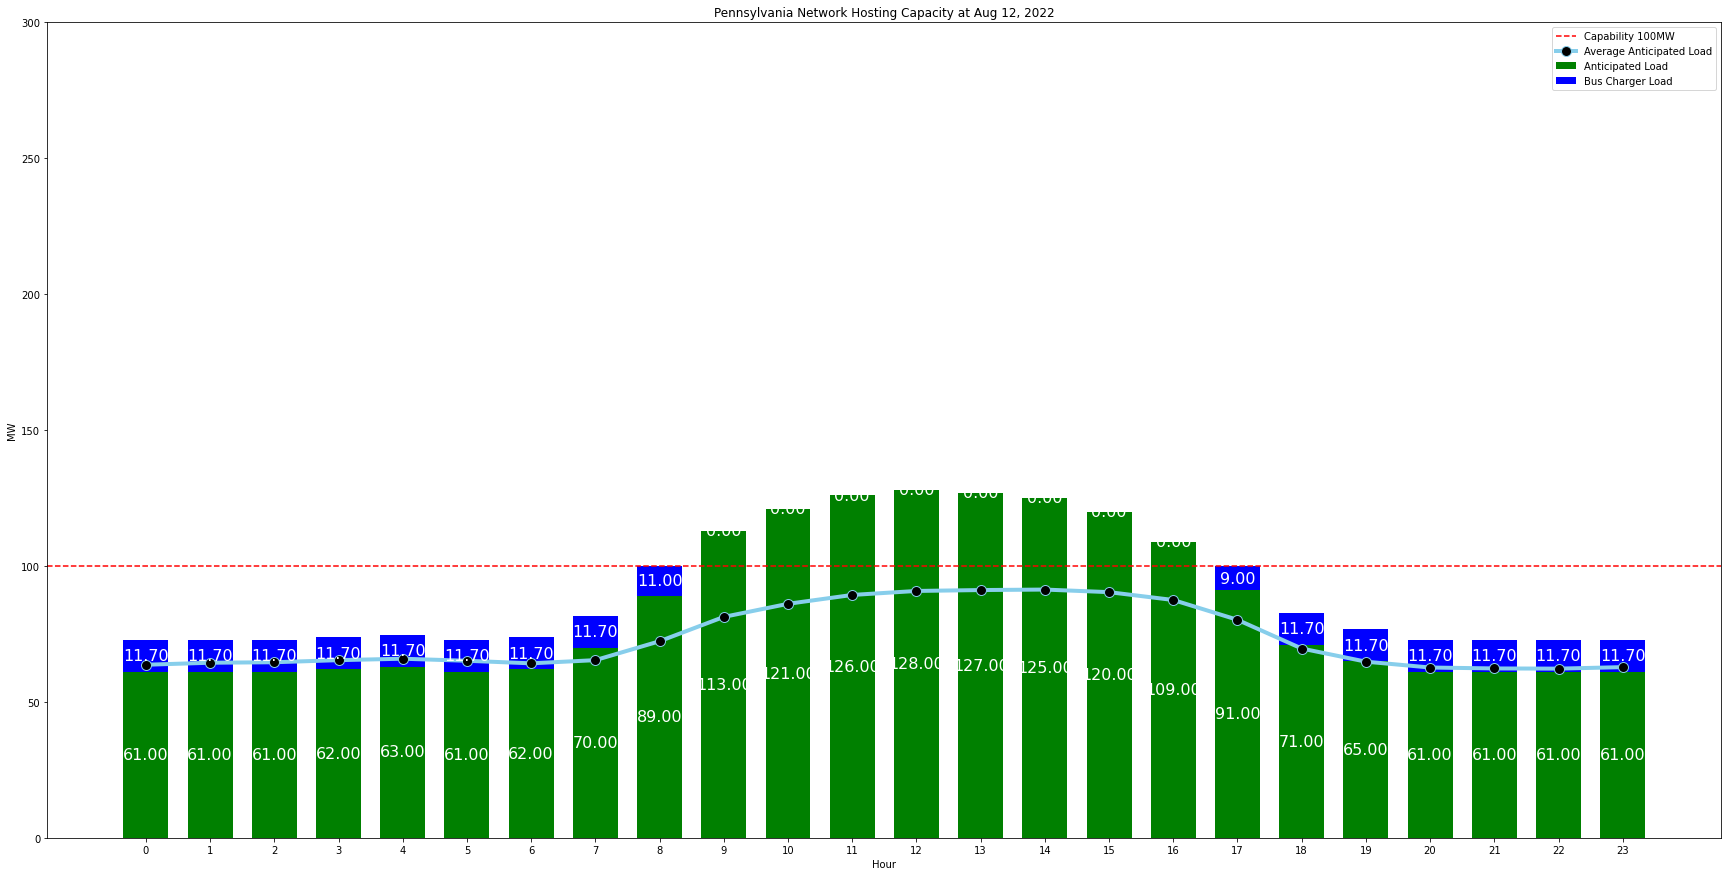

In [21]:
#26 chargers @450kW 
charger = [11.7, 11.7, 11.7, 11.7, 11.7, 11.7, 11.7, 11.7, 11, 0, 0, 0, 0, 0, 0, 0, 0,
          9, 11.7, 11.7, 11.7, 11.7, 11.7, 11.7]
load = []
for i in range(0,24):
    ld = dff['Pennsylvania'].loc[5352+i]
    load.append(float(ld))
avg_load = []
for i in range(0,24):
    avg = dff.loc[dff['Hour'] == i, 'Pennsylvania'].mean()
    avg = "%.2f" %avg
    avg_load.append(float(avg))
width = 0.7

fig, ax = plt.subplots(figsize=(30,15))
plt.axhline(y=100, color='r', linestyle='--', label='Capability 100MW')
plt.plot(labels, avg_load, marker='o', markerfacecolor='black', markersize=10, color='skyblue', linewidth=4, label='Average Anticipated Load')
ax1 = ax.bar(labels, load, width, color='green', label='Anticipated Load')
ax2 = ax.bar(labels, charger, width, color='blue', yerr=None, bottom=load, label='Bus Charger Load')
for r1, r2 in zip(ax1, ax2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%.2f" % h1, ha="center", va="center", color="white", fontsize=16)
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%.2f" % h2, ha="center", va="center", color="white", fontsize=16)
ax.set_xlabel('Hour')
ax.set_ylabel('MW')
ax.set_title('Pennsylvania Network Hosting Capacity at Aug 12, 2022')
ax.legend(loc='best')
plt.ylim(0,300)
plt.show()